# 5. Grouping by Time and another Column

### Objectives

* Use `Grouper` to group by time to give the exact same output as `resample`
* Independently group a column and then by an amount of time with `groupby.resample`
* Simultaneously group by time and another column by using `Grouper` within `groupby`

## Group by an amount of time with `Grouper` instead of `resample`
In the previous notebooks, we learned how to group by an amount of time with `resample`. Let's do that again here finding the average salary of every employee based on a span of 5 years.

In [1]:
import pandas as pd
emp = pd.read_csv('../data/employee.csv', parse_dates=['hire_date'], index_col='hire_date')
emp.head()

,title,dept,salary,race,gender
hire_date,,,,,
2015-02-03,POLICE OFFICER,Houston Police Department-HPD,45279.0,White,Male
1982-02-08,ENGINEER/OPERATOR,Houston Fire Department (HFD),63166.0,White,Male
1984-11-26,SENIOR POLICE OFFICER,Houston Police Department-HPD,66614.0,Black,Male
2012-03-26,ENGINEER,Public Works & Engineering-PWE,71680.0,Asian,Male
2013-11-04,CARPENTER,Houston Airport System (HAS),42390.0,White,Male


In [2]:
emp.resample('5Y').agg({'salary': 'mean'}).round(-3)

,salary
hire_date,
1958-12-31,81000.0
1963-12-31,NaN
1968-12-31,90000.0
1973-12-31,67000.0
1978-12-31,89000.0
1983-12-31,69000.0
1988-12-31,68000.0
1993-12-31,63000.0
1998-12-31,63000.0


## Replicating `resample` with `groupby` + `Grouper`
The following syntax is a bit strange, so it might take reading it a few times to understand what is going on. 

You can group by time within the `groupby` method but you must use the `pd.Grouper` type to specify the frequency (the offset alias).

## Specify the frequency
The main parameter for `Grouper` is `freq`. Set it to the offset alias.

In [3]:
tg = pd.Grouper(freq='5Y')

### Think of `pd.Grouper` like a dictionary that holds information
The only use case for this object is to pass it into `groupby`. It might be easier to just think of it as a dictionary that holds the frequency. Once we pass it to `groupby`, we can aggregate like we normally do and get the same result as we did with `resample`.

In [4]:
emp.groupby(tg).agg({'salary':'mean'}).round(-3)

,salary
hire_date,
1958-12-31,81000.0
1963-12-31,NaN
1968-12-31,90000.0
1973-12-31,67000.0
1978-12-31,89000.0
1983-12-31,69000.0
1988-12-31,68000.0
1993-12-31,63000.0
1998-12-31,63000.0


# Grouping by an amount of time and another column
There are two different ways to group by time and another column. The difference is subtle but important and can make a difference in the result. The datetime column and the other column can either be grouped **together** or grouped **independently**.

Let's say we wanted to find the average salary over 5-year time periods for each gender.

### Group together
To group gender and a 5-year time span together, we must use `groupby`. We will simply pass a list of both the `Grouper` object and the column name to groupby. 

In [5]:
tg = pd.Grouper(freq='5Y')
groups = ['gender', tg]

emp.groupby(groups).agg({'salary':'mean'}).round(-3)

salary
gender hire_date          
Female 1978-12-31      NaN
       1983-12-31  55000.0
       1988-12-31  59000.0
       1993-12-31  56000.0
       1998-12-31  60000.0
       2003-12-31  51000.0
       2008-12-31  49000.0
       2013-12-31  52000.0
       2018-12-31  39000.0
Male   1958-12-31  81000.0
       1968-12-31  90000.0
       1973-12-31  67000.0
       1978-12-31  89000.0
       1983-12-31  72000.0
       1988-12-31  70000.0
       1993-12-31  67000.0
       1998-12-31  65000.0
       2003-12-31  63000.0
       2008-12-31  56000.0
       2013-12-31  51000.0
       2018-12-31  40000.0

### Datetimes are the same
Notice, how the datetimes for both female and male groups are the same. This is not going to be the case below.

## Group independently
To group independently, we first group the non-datetime column with the `groupby` method. The GroupBy object has a `resample` method which allows you to then group by an amount of time **within** the groups you just created. You use it just like it was being called from a DataFrame. Notice how the hire dates for males and females are different.

In [6]:
emp.groupby('gender').resample('5Y').agg({'salary':'mean'}).round(-3)

salary
gender hire_date          
Female 1975-12-31      NaN
       1980-12-31  56000.0
       1985-12-31  56000.0
       1990-12-31  56000.0
       1995-12-31  58000.0
       2000-12-31  53000.0
       2005-12-31  54000.0
       2010-12-31  50000.0
       2015-12-31  45000.0
       2020-12-31  36000.0
Male   1958-12-31  81000.0
       1963-12-31      NaN
       1968-12-31  90000.0
       1973-12-31  67000.0
       1978-12-31  89000.0
       1983-12-31  72000.0
       1988-12-31  70000.0
       1993-12-31  67000.0
       1998-12-31  65000.0
       2003-12-31  63000.0
       2008-12-31  56000.0
       2013-12-31  51000.0
       2018-12-31  40000.0

In [7]:
emp[emp['gender'] == 'Female'].index.min()

Timestamp('1975-06-09 00:00:00')

## Different results
Its important to see that you will get different results depending on whether you group together or group independently. The reason the results are different is because the earliest male and female employees don't have a hire date that is an exact 5 year multiple difference. The earliest hire date for female employees was 1975 while it is 1958 for males. If the first male and female employees were both hired in 1958, then the returned datetime index would have been the same.

## Using a pivot table with `Grouper` for easier comparisons
You can pass a `Grouper` object to a pivot table to get a nice final product. This groups gender together with time.

In [11]:
emp.pivot_table(index=tg, columns='gender', values='salary').round(-3)

gender,Female,Male
hire_date,,
1958-12-31,NaN,81000.0
1968-12-31,NaN,90000.0
1973-12-31,NaN,67000.0
1978-12-31,NaN,89000.0
1983-12-31,55000.0,72000.0
1988-12-31,59000.0,70000.0
1993-12-31,56000.0,67000.0
1998-12-31,60000.0,65000.0
2003-12-31,51000.0,63000.0


## Using `Grouper` on a datetime column
If your datetime column is not in the index, you can still use `Grouper`. Just specify the column name with the `key` parameter. See the example below with `hire_date` not in the index.

In [12]:
emp2 = pd.read_csv('../data/employee.csv', parse_dates=['hire_date'])
emp2.head()

,title,dept,salary,race,gender,hire_date
0,POLICE OFFICER,Houston Police Department-HPD,45279.0,White,Male,2015-02-03
1,ENGINEER/OPERATOR,Houston Fire Department (HFD),63166.0,White,Male,1982-02-08
2,SENIOR POLICE OFFICER,Houston Police Department-HPD,66614.0,Black,Male,1984-11-26
3,ENGINEER,Public Works & Engineering-PWE,71680.0,Asian,Male,2012-03-26
4,CARPENTER,Houston Airport System (HAS),42390.0,White,Male,2013-11-04


In [13]:
tg2 = pd.Grouper(freq='10Y', key='hire_date')
emp2.groupby(['gender', tg2]).agg({'salary':'mean'})

salary
gender hire_date               
Female 1978-12-31           NaN
       1988-12-31  57194.520000
       1998-12-31  57445.807692
       2008-12-31  49992.063380
       2018-12-31  45392.711111
Male   1958-12-31  81239.000000
       1968-12-31  89590.000000
       1978-12-31  85376.142857
       1988-12-31  71106.305085
       1998-12-31  65637.036364
       2008-12-31  58999.064267
       2018-12-31  45797.629944

# Exercises

## Problem 1
<span  style="color:green; font-size:16px">Read in the energy consumption dataset. Find the average energy consumption per sector per 10 year time span beginning from the first year of data. Return the results as both a groupby and a pivot table. Experiment with adding 'S' to the end of your offset alias. How does this change the results?</span>

In [21]:
import pandas as pd
import numpy as np
energy = pd.read_csv('../data/energy_consumption.csv', parse_dates=['date'], index_col='date')
td = pd.Grouper(freq='10Y')
energy.head()

,source,energy (btu)
date,,
1973-01-01,residential,1932.187
1973-02-01,residential,1687.255
1973-03-01,residential,1497.067
1973-04-01,residential,1177.661
1973-05-01,residential,1015.008


In [23]:
energy.groupby(['source', tg]).agg({'energy (btu)':['sum', np.size]}).astype('int').head()

energy (btu)     
                               sum size
source     date                        
commercial 1973-12-31         9544   12
           1978-12-31        49675   60
           1983-12-31        53650   60
           1988-12-31        59036   60
           1993-12-31        67280   60

In [26]:
df = energy.pivot_table(index=tg, columns='source', values='energy (btu)', aggfunc='sum').astype('int')

In [27]:
df

source,commercial,industrial,residential,transportation
date,,,,
1973-12-31,9544,32622,14895,18612
1978-12-31,49675,157550,76657,95904
1983-12-31,53650,151717,77769,97945
1988-12-31,59036,146710,81365,104318
1993-12-31,67280,159712,87711,112101
1998-12-31,75621,172412,94048,121496
2003-12-31,85390,167360,101902,132362
2008-12-31,89871,162059,106554,141020
2013-12-31,89274,152785,105098,133274


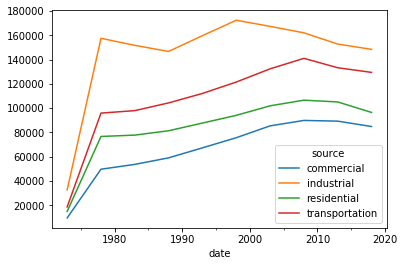

In [29]:
%matplotlib inline
df.plot()